# VQ-VAE (Vector Quantized Variational Auto-Encoder)

Lecture 12 | CMU ANLP Spring 2026 | Instructor: Sean Welleck

VQ-VAE learns discrete representations of images using a learned codebook of vectors.

The model has three parts:
1. Encoder: maps images to continuous vectors
2. Vector Quantizer: replaces each vector with the nearest codebook vector  
3. Decoder: reconstructs images from the quantized codes

The quantization creates a discrete representation, which then lets us use autoregressive models for generation.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

## 1. Vector Quantizer

The Vector Quantizer learns a codebook of K embedding vectors, each of dimension D.

The quantizer takes encoder output $z_e$ of shape [B, D, H, W] and for each spatial location, finds the nearest codebook vector. It computes distances between each latent vector and all K codebook vectors, selects the closest one, and outputs a quantized representation $z_q$.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=32, beta=0.25):
        super().__init__()
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        nn.init.uniform_(self.codebook.weight, -1/num_embeddings, 1/num_embeddings)
        self.beta = beta
        
    def forward(self, z_e):
        B, D, H, W = z_e.shape
        # Reshape: [B, D, H, W] → [B*H*W, D]
        flat = z_e.permute(0, 2, 3, 1).reshape(-1, D)
        
        # Compute L2 distances to all codebook vectors
        # ||a - b||^2 = ||a||^2 - 2<a,b> + ||b||^2
        distances = (
            flat.pow(2).sum(1, keepdim=True)
            - 2 * flat @ self.codebook.weight.T
            + self.codebook.weight.pow(2).sum(1)
        )
        
        # Find nearest codebook vector for each position
        indices = distances.argmin(dim=1)  # [B*H*W]
        
        # Look up the quantized vectors
        z_q = self.codebook(indices).view(B, H, W, D).permute(0, 3, 1, 2)  # [B, D, H, W]
        
        # VQ losses
        # Codebook loss: move codebook vectors toward encoder outputs
        codebook_loss = F.mse_loss(z_e, z_q.detach())
        
        # Commitment loss: encourage encoder to commit to codebook
        commitment_loss = self.beta * F.mse_loss(z_e.detach(), z_q)
        
        # Straight-through estimator: copy gradients from z_q to z_e
        z_q = z_e + (z_q - z_e).detach()
        
        return z_q, indices.view(B, H, W), codebook_loss + commitment_loss

# Test the quantizer
vq = VectorQuantizer(num_embeddings=128, embedding_dim=32)
test_input = torch.randn(4, 32, 7, 7)
z_q, indices, loss = vq(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {z_q.shape}")
print(f"Indices shape: {indices.shape}")
print(f"Indices range: [{indices.min()}, {indices.max()}]")
print(f"VQ loss: {loss.item():.4f}")

Input shape: torch.Size([4, 32, 7, 7])
Output shape: torch.Size([4, 32, 7, 7])
Indices shape: torch.Size([4, 7, 7])
Indices range: [0, 126]
VQ loss: 1.2562


## 2. Encoder and Decoder

The encoder and decoder are simple convolutional networks. The encoder takes 28x28 MNIST images and applies 2 conv layers with stride 2 (downsampling), producing a 7x7 spatial grid with 32 channels (49 vectors to quantize). The decoder takes quantized latent codes and applies 2 transposed conv layers (upsampling) to reconstruct 28x28 images.

In [7]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, embedding_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(embedding_dim, embedding_dim, kernel_size=3, stride=2, padding=1),
        )
    
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, embedding_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(embedding_dim, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  
        )
    
    def forward(self, z):
        return self.net(z)


# Test the encoder/decoder
encoder = Encoder(embedding_dim=32)
decoder = Decoder(embedding_dim=32)

test_img = torch.randn(4, 1, 28, 28)  # Batch of 4 MNIST-sized images
z_e = encoder(test_img)
recon = decoder(z_e)

print(f"Input: {test_img.shape}")
print(f"Encoded: {z_e.shape}")
print(f"Reconstructed: {recon.shape}")

Input: torch.Size([4, 1, 28, 28])
Encoded: torch.Size([4, 32, 7, 7])
Reconstructed: torch.Size([4, 1, 28, 28])


## 3. Load MNIST Data

We train on MNIST handwritten digits (28x28 grayscale images).

In [8]:
# Load MNIST dataset
train_dataset = datasets.MNIST(
    root=".", 
    train=True, 
    download=True,
    transform=transforms.ToTensor()
)

# Create data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=128, 
    shuffle=True
)

print(f"Dataset size: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")

Dataset size: 60000
Number of batches: 469


## 4. Training the VQ-VAE

We train for a few epochs and track reconstruction loss (how well we reconstruct the input), VQ loss (codebook + commitment losses), and codebook usage (how many of our K=128 codebook vectors are actually used).

In [9]:
# Initialize model components
embedding_dim = 32
num_embeddings = 128

encoder = Encoder(embedding_dim=embedding_dim)
quantizer = VectorQuantizer(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
decoder = Decoder(embedding_dim=embedding_dim)

# Optimizer
params = list(encoder.parameters()) + list(quantizer.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

# Training loop
num_epochs = 3
train_losses = []

for epoch in range(num_epochs):
    total_recon_loss = 0
    total_vq_loss = 0
    all_indices = []
    
    for batch_idx, (images, _) in enumerate(train_loader):
        # Forward pass
        z_e = encoder(images)
        z_q, indices, vq_loss = quantizer(z_e)
        reconstructed = decoder(z_q)
        
        # Losses
        recon_loss = F.mse_loss(reconstructed, images)
        loss = recon_loss + vq_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track statistics
        total_recon_loss += recon_loss.item()
        total_vq_loss += vq_loss.item()
        all_indices.append(indices.flatten())
        
        if (batch_idx + 1) % 100 == 0:
            avg_recon = total_recon_loss / (batch_idx + 1)
            avg_vq = total_vq_loss / (batch_idx + 1)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Recon Loss: {avg_recon:.4f}, VQ Loss: {avg_vq:.4f}")
    
    # Epoch statistics
    avg_recon = total_recon_loss / len(train_loader)
    avg_vq = total_vq_loss / len(train_loader)
    
    # Calculate codebook usage
    all_indices = torch.cat(all_indices)
    unique_codes = torch.unique(all_indices).numel()
    usage_percent = 100 * unique_codes / num_embeddings
    
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1} Summary:")
    print(f"  Reconstruction Loss: {avg_recon:.4f}")
    print(f"  VQ Loss: {avg_vq:.4f}")
    print(f"  Codebook Usage: {unique_codes}/{num_embeddings} ({usage_percent:.1f}%)")
    print(f"{'='*70}\n")
    
    train_losses.append((avg_recon, avg_vq))


Epoch [1/3], Batch [100/469], Recon Loss: 0.1286, VQ Loss: 0.1485
Epoch [1/3], Batch [200/469], Recon Loss: 0.0802, VQ Loss: 0.0803
Epoch [1/3], Batch [300/469], Recon Loss: 0.0581, VQ Loss: 0.0546
Epoch [1/3], Batch [400/469], Recon Loss: 0.0460, VQ Loss: 0.0416

Epoch 1 Summary:
  Reconstruction Loss: 0.0404
  VQ Loss: 0.0359
  Codebook Usage: 81/128 (63.3%)

Epoch [2/3], Batch [100/469], Recon Loss: 0.0072, VQ Loss: 0.0029
Epoch [2/3], Batch [200/469], Recon Loss: 0.0069, VQ Loss: 0.0030
Epoch [2/3], Batch [300/469], Recon Loss: 0.0067, VQ Loss: 0.0031
Epoch [2/3], Batch [400/469], Recon Loss: 0.0065, VQ Loss: 0.0031

Epoch 2 Summary:
  Reconstruction Loss: 0.0064
  VQ Loss: 0.0032
  Codebook Usage: 71/128 (55.5%)

Epoch [3/3], Batch [100/469], Recon Loss: 0.0057, VQ Loss: 0.0034
Epoch [3/3], Batch [200/469], Recon Loss: 0.0056, VQ Loss: 0.0034
Epoch [3/3], Batch [300/469], Recon Loss: 0.0055, VQ Loss: 0.0034
Epoch [3/3], Batch [400/469], Recon Loss: 0.0055, VQ Loss: 0.0034

Epoch 3

## 4.5 Visualizing the Vector Quantization Lookup

The figure shows what happens during quantization. The left shows the original image. The right shows discrete codebook indices after quantization. 

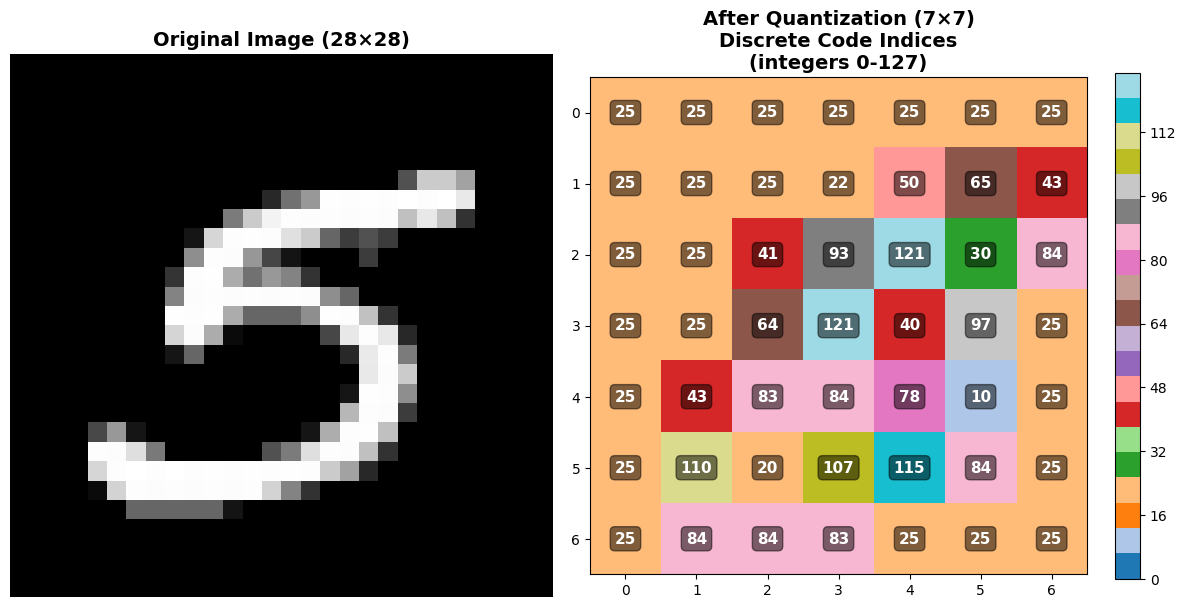

In [13]:
# Visualize the quantization process for a single image
with torch.no_grad():
    sample_img, _ = next(iter(train_loader))
    sample_img = sample_img[0:1] 
    
    z_e = encoder(sample_img)
    z_q, codes, _ = quantizer(z_e)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 1. Original image
axes[0].imshow(sample_img[0, 0], cmap='gray')
axes[0].set_title('Original Image (28×28)', fontsize=14, fontweight='bold')
axes[0].axis('off')

# 2. After quantization 
im = axes[1].imshow(codes[0], cmap='tab20', interpolation='nearest', vmin=0, vmax=127)
axes[1].set_title('After Quantization (7×7)\nDiscrete Code Indices\n(integers 0-127)', 
                 fontsize=14, fontweight='bold')
for i in range(7):
    for j in range(7):
        axes[1].text(j, i, str(codes[0, i, j].item()), 
                    ha='center', va='center', color='white', 
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.5))
axes[1].set_xticks(range(7))
axes[1].set_yticks(range(7))
plt.colorbar(im, ax=axes[1], fraction=0.046, ticks=range(0, 128, 16))

plt.tight_layout()
plt.show()


## 5. Visualize Reconstructions

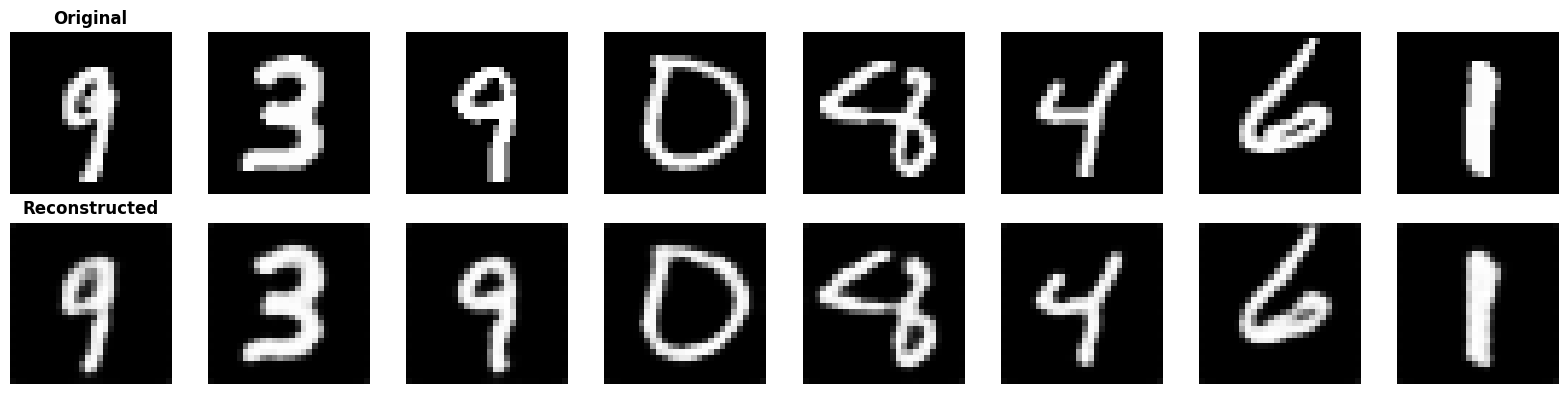


Mean Squared Error: 0.0052


In [14]:
# Get a batch of test images
encoder.eval()
quantizer.eval()
decoder.eval()

with torch.no_grad():
    test_images, _ = next(iter(train_loader))
    test_images = test_images[:8]  # Use first 8 images
    
    z_e = encoder(test_images)
    z_q, codes, _ = quantizer(z_e)
    reconstructions = decoder(z_q)

# Visualize
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    # Original
    axes[0, i].imshow(test_images[i, 0], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=12, fontweight='bold')
    
    # Reconstruction
    axes[1, i].imshow(reconstructions[i, 0], cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Show reconstruction error
mse = F.mse_loss(reconstructions, test_images)
print(f"\nMean Squared Error: {mse.item():.4f}")

## 6. Codebook Usage

We visualize which codebook vectors are used most frequently.

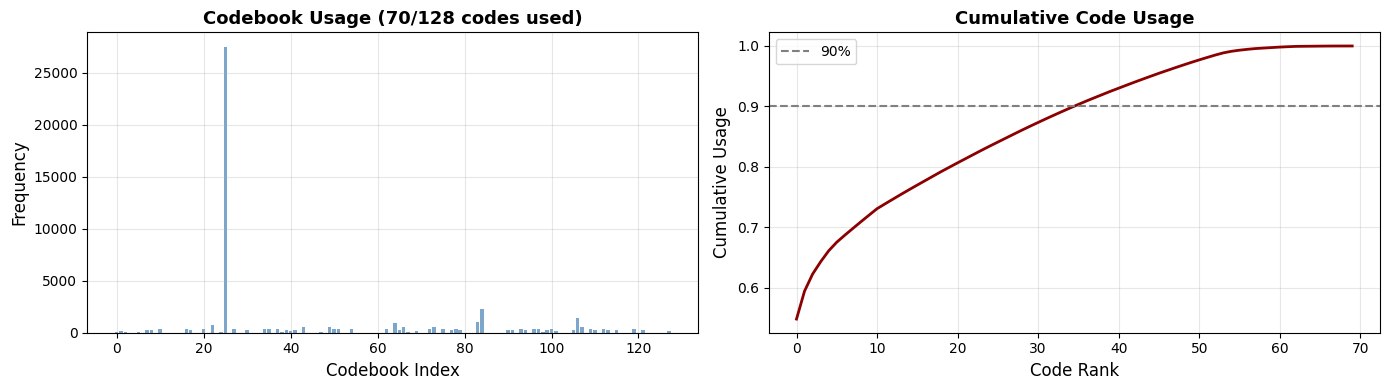


Top 36 codes account for 90% of usage
Most common codes: [25, 84, 106, 83, 64, 22, 49, 73, 43, 66]


In [15]:
# Analyze codebook usage across the dataset
from collections import Counter

all_codes = []
with torch.no_grad():
    for images, _ in train_loader:
        z_e = encoder(images)
        _, codes, _ = quantizer(z_e)
        all_codes.extend(codes.flatten().tolist())
        
        # Just use first few batches for speed
        if len(all_codes) > 50000:
            break

# Count code frequencies
code_counts = Counter(all_codes)
used_codes = len(code_counts)

# Plot code usage histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Histogram of code frequencies
codes_sorted = sorted(code_counts.items())
code_ids = [c[0] for c in codes_sorted]
frequencies = [c[1] for c in codes_sorted]

ax1.bar(code_ids, frequencies, color='steelblue', alpha=0.7)
ax1.set_xlabel('Codebook Index', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title(f'Codebook Usage ({used_codes}/{num_embeddings} codes used)', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# Cumulative distribution
sorted_freqs = sorted(frequencies, reverse=True)
cumsum = np.cumsum(sorted_freqs) / np.sum(sorted_freqs)
ax2.plot(cumsum, color='darkred', linewidth=2)
ax2.axhline(0.9, color='gray', linestyle='--', label='90%')
ax2.set_xlabel('Code Rank', fontsize=12)
ax2.set_ylabel('Cumulative Usage', fontsize=12)
ax2.set_title('Cumulative Code Usage', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find how many codes account for 90% of usage
num_90 = np.where(cumsum >= 0.9)[0][0] + 1
print(f"\nTop {num_90} codes account for 90% of usage")
print(f"Most common codes: {[c[0] for c in code_counts.most_common(10)]}")